In [1]:
#Quantum Programming Homework 4: Quantum Cellular Automata and Post-Selection
#Nathan Taylor
#04/05/22

In [2]:
import cirq
import matplotlib.pyplot as plt
import numpy as np
import random
from cirq.contrib.svg import SVGCircuit, circuit_to_svg

In [3]:
#Functions
#a) Controlled Hadamards
def fullCH(qt, qubits):
    ops = []
    #normal
    if qt < len(qubits) - 1 and qt > 0:
        ops.append(cirq.ry(np.pi/4)(qubits[qt]))
        ops.append(cirq.CZ(qubits[qt], qubits[qt-1]))
        ops.append(cirq.CZ(qubits[qt], qubits[qt+1]))
        ops.append(cirq.ry(-np.pi/4)(qubits[qt]))
    elif qt == len(qubits) - 1:#partial
        ops.append(cirq.ry(np.pi/4)(qubits[qt]))
        ops.append(cirq.CZ(qubits[qt], qubits[qt-1]))
        ops.append(cirq.ry(-np.pi/4)(qubits[qt]))
    elif qt == 0:
        ops.append(cirq.ry(np.pi/4)(qubits[qt]))
        ops.append(cirq.CZ(qubits[qt], qubits[qt+1]))
        ops.append(cirq.ry(-np.pi/4)(qubits[qt]))
    return ops

#b) Gate layers for QCA - 2 methods
#Poor gate scheduling
def stackedCH(qubits):
    ops = []
    #split into 2 because even and odd bonds dont commute
    for i in range(0, len(qubits), 2):
        ops.append(fullCH(i, qubits))#really bad scheduling mate
    for i in range(1, len(qubits), 2):
        ops.append(fullCH(i, qubits))
    return ops

#Efficient gate scheduling
def parallelCH(qubits):
    ops = []
    y1_mom = []
    y2_mom = []
    cz1_mom = []
    cz2_mom = []
    y3_mom = []
    
    #even sites
    for i in range(len(qubits)):
        if i % 2 == 0:
            y1_mom.append(cirq.ry(np.pi/4)(qubits[i]))
            y2_mom.append(cirq.ry(-np.pi/4)(qubits[i]))
            if i < len(qubits) - 1:
                cz1_mom.append(cirq.CZ(qubits[i],qubits[i+1]))
        else:
            y2_mom.append(cirq.ry(np.pi/4)(qubits[i]))
            y3_mom.append(cirq.ry(-np.pi/4)(qubits[i]))
            if i < len(qubits) - 1:
                cz2_mom.append(cirq.CZ(qubits[i],qubits[i+1]))                
                
    ops.append(y1_mom)
    ops.append(cirq.Moment(cz1_mom))
    ops.append(cirq.Moment(cz2_mom))
    ops.append(cirq.Moment(y2_mom))
    ops.append(cirq.Moment(cz1_mom))
    ops.append(cirq.Moment(cz2_mom))
    ops.append(y3_mom)
    return ops

#c) Evolve and Measure
def runCircuit(oplist, counts):#Run the circuit
    sim = cirq.Simulator()
    circuit = cirq.Circuit(oplist)
    sample = sim.run(circuit, repetitions=counts)
    statelist = str(sample)[2:].split(", ")#list of states for each qubit
    return statelist

def ZExpectation(statelist):#Measure the Z expectation value of each qubit
    L = len(statelist)#number of qubits
    counts = len(statelist[0])
    
    z_count = np.zeros(L)
    for q in range(L):#qubit iterator dont go over the edge
        for c in range(counts):#each run
            z_count[q] += int(statelist[q][c]) #add up the number of times each qubit was a 1
            
    z_avg = z_count / counts
    return z_avg

#d) Depolarizing Noise
def noisy_moment(i, qubits, p):
    op = []
    pauli = [cirq.Z, cirq.Y, cirq.X]#error types
    bits = [qubits[i], qubits[i+1]]
    if random.random() < p:
        err_qbit = random.choice(bits)
        err_gate = random.choice(pauli)
        op.append(err_gate(err_qbit))
        #print(err_gate,err_qbit)
    return op           

def errorCH(qubits):
    p = 0.01 # 1% error for each 2 qubit gate
    ops = []
    y1_mom = []
    y2_mom = []
    cz1_mom = []
    cz2_mom = []
    e1_mom=[]
    e2_mom=[]
    e3_mom=[]
    e4_mom=[]
    y3_mom = []
    
    #even/odd sites
    for i in range(len(qubits)):
        if i % 2 == 0:
            y1_mom.append(cirq.ry(np.pi/4)(qubits[i]))
            y2_mom.append(cirq.ry(-np.pi/4)(qubits[i]))
            if i < len(qubits) - 1:
                cz1_mom.append(cirq.CZ(qubits[i],qubits[i+1]))
                e1_mom.append(noisy_moment(i, qubits, p))#add to error moment
                e3_mom.append(noisy_moment(i, qubits, p))#add to error moment
        else:
            y2_mom.append(cirq.ry(np.pi/4)(qubits[i]))
            y3_mom.append(cirq.ry(-np.pi/4)(qubits[i]))
            if i < len(qubits) - 1:
                cz2_mom.append(cirq.CZ(qubits[i],qubits[i+1]))
                e2_mom.append(noisy_moment(i, qubits, p))#add to error moment
                e4_mom.append(noisy_moment(i, qubits, p))#add to error moment
    
    ops.append(y1_mom)#even +y rotation
    ops.append(cirq.Moment(cz1_mom))
    ops.append(cirq.Moment(e1_mom))
    ops.append(cirq.Moment(cz2_mom))
    ops.append(cirq.Moment(e2_mom))
    ops.append(cirq.Moment(y2_mom))
    ops.append(cirq.Moment(cz1_mom))
    ops.append(cirq.Moment(e3_mom))
    ops.append(cirq.Moment(cz2_mom))
    ops.append(cirq.Moment(e4_mom))
    ops.append(y3_mom)
    return ops

#e) Post-Selection
def ZZEnergy(state):
    zzenergy = 0
    for i in range(len(state)-1):#qubit iterator dont go over the edge
        if state[i] == state[i+1]:#adjacent qubits are in the same state
            zzenergy += 1
        else:
            zzenergy += -1
    return zzenergy

def ZPostSelect(statelist, initial_state):
    L = len(statelist)#number of qubits
    counts = len(statelist[0]) 
    
    z_count = np.zeros(L)
    good_state_count = 0
    for c in range(counts):#each run
        current_state = ""
        for q in range(L):#reconstruct the readout states
            current_state += statelist[q][c]

        #The missing CZ gates on the boundaries act like there are qubits there in the 0 state
        #These need to be counted in the conserved ZZ energy so here we add on 0s to the ends of our read states
        virtual_state = "0" + current_state + "0"
        virtual_init = "0" + initial_state + "0"
        
        #ZZEnergy is conserved by this algorithm so we can toss any state where it isn't the same
        if ZZEnergy(virtual_state) == ZZEnergy(virtual_init):
            good_state_count += 1
            for q in range(L):
                z_count[q] += int(statelist[q][c])

    print("Valid States: ", good_state_count/counts*100, "%")
    z_postavg = z_count / good_state_count
    return z_postavg

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


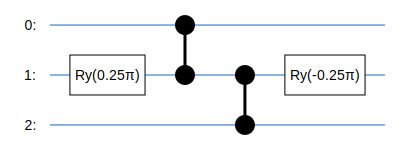

In [4]:
#a) Controlled Hadamards
qline = cirq.LineQubit.range(3)
Vlist = fullCH(1, qline)
Vcir = cirq.Circuit(Vlist)
SVGCircuit(Vcir)

In [5]:
#Test Cases to ensure it works
#00, 11, 01, 10
sim = cirq.Simulator()
print("State of Adjacent Qubits, Readout Probability")
for i in range(2):
    for j in range(2):
        Vtest = []
        if i:
            Vtest.append(cirq.X(qline[0]))
        if j:
            Vtest.append(cirq.X(qline[2]))
        Vtest.append(fullCH(1,qline))
        Vtest.append(cirq.measure(qline[1], key='z'))
        Vcircuit = cirq.Circuit(Vtest)
        sample = sim.run(Vcircuit, repetitions=1000)
        print("\t" + str(i)+str(j)+"\t\t", sample.histogram(key='z'))

State of Adjacent Qubits, Readout Probability
	00		 Counter({0: 1000})
	01		 Counter({0: 522, 1: 478})
	10		 Counter({1: 529, 0: 471})
	11		 Counter({0: 1000})


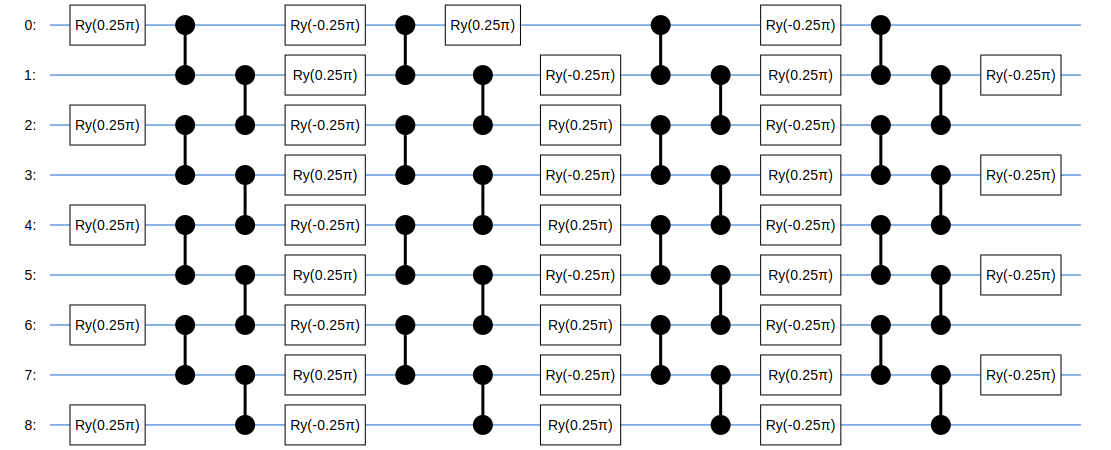

In [6]:
#b) Gate layers for QCA - 2 methods
L=9
qubits = cirq.LineQubit.range(L)
layertest = []
for i in range(2): layertest.append(parallelCH(qubits))
SVGCircuit(cirq.Circuit(layertest))

Were are plotting the probability of each state having a particle in it, not the probability of a particle being in each state. The total probability of a particle being in all locations must be 1. The total probability of all states having a particle does not have to be 1, especially if the number of particles changes.

The ZZ Energy is conserved in this QCA. By comparing the energy before and after we can determine if an error occurred that did not conserve ZZ energy and not include those states in the calculations.
$$
O=\sum_0^7 Z_jZ_{j+1}+Z_0Z_8
$$

Post-Selection: Valid States after Measurement
Valid States:  100.0 %
Valid States:  100.0 %
Valid States:  56.00000000000001 %
Valid States:  100.0 %
Valid States:  12.7 %
Valid States:  100.0 %
Valid States:  100.0 %
Valid States:  39.800000000000004 %
Valid States:  13.200000000000001 %
Valid States:  16.0 %


Text(0, 0.5, 'Qubit')

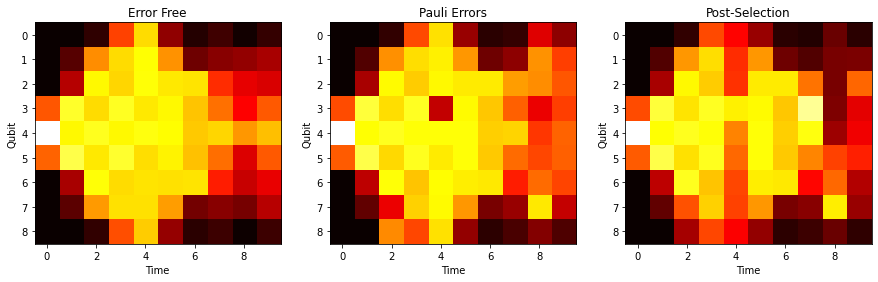

In [7]:
#cde) Evolution Comparison
counts = 1000
L = 9
initial_state = "000010000"
print("Post-Selection: Valid States after Measurement")
pure_matrix = np.zeros([0, L])
err_matrix = np.zeros([0, L])
post_matrix = np.zeros([0, L])

for t in range(1,11):
    pure_list = []
    err_list = []
    pure_list.append(cirq.X(qubits[4]))
    err_list.append(cirq.X(qubits[4]))#single particle initialized
    for j in range(t):
        err_list.append(errorCH(qubits))
        pure_list.append(parallelCH(qubits))
    pure_list.append(cirq.measure(*qubits, key='z'))
    err_list.append(cirq.measure(*qubits, key='z'))
    
    #c) Pure Evolution
    pure_avg = ZExpectation(runCircuit(pure_list, counts))
    pure_matrix = np.append(pure_matrix, [pure_avg], axis=0)
    
    #d)Error Calculations
    stateList = runCircuit(err_list, counts)#to ensure they use the same measurements
    qerr_avg = ZExpectation(stateList)
    err_matrix = np.append(err_matrix, [qerr_avg], axis=0)
    
    #e) Post Selection Energy Calculations
    post_avg = ZPostSelect(stateList, initial_state)
    post_matrix = np.append(post_matrix, [post_avg], axis=0)

    
fig, axes = plt.subplots(1,3,figsize=(15,15))
plt.subplot(1,3,1)
plt.imshow(np.transpose(pure_matrix), cmap='hot')
plt.title("Error Free")
plt.xlabel("Time")
plt.ylabel("Qubit")

plt.subplot(1,3,2)
plt.imshow(np.transpose(err_matrix), cmap='hot')
plt.title("Pauli Errors")
plt.xlabel("Time")
plt.ylabel("Qubit")

plt.subplot(1,3,3)
plt.imshow(np.transpose(post_matrix), cmap='hot')
plt.title("Post-Selection")
plt.xlabel("Time")
plt.ylabel("Qubit")

The results are much better with post-selection. Post-Selection doesn't account for when multiple errors happen that bring you back to the initial Z energy. It also doesn't catch Z errors that happen after the last set of CZ gates. Using post-selection, we can get an idea of the error rate. It seems like the error rate doesn't monotonically increase.